## Data Preprocessing



**CLICKS DATASET FILE DESCRIPTION**

The file yoochoose-clicks.dat comprising the clicks of the users over the items.
Each record/line in the file has the following fields/format: Session ID, Timestamp, Item ID, Category

- Session ID – the id of the session. In one session there are one or many clicks. Could be represented as an integer number.
- Timestamp – the time when the click occurred. Format of YYYY-MM-DDThh:mm:ss.SSSZ
- Item ID – the unique identifier of the item that has been clicked. Could be represented as an integer number.
- Category – the context of the click. The value "S" indicates a special offer, "0" indicates  a missing value, a number between 1 to 12 indicates a real category identifier,
 any other number indicates a brand. E.g. if an item has been clicked in the context of a promotion or special offer then the value will be "S", if the context was a brand i.e BOSCH,
 then the value will be an 8-10 digits number. If the item has been clicked under regular category, i.e. sport, then the value will be a number between 1 to 12. 
 
**BUYS DATSET FILE DESCRIPTION**

The file yoochoose-buys.dat comprising the buy events of the users over the items.
Each record/line in the file has the following fields: Session ID, Timestamp, Item ID, Price, Quantity

- Session ID - the id of the session. In one session there are one or many buying events. Could be represented as an integer number.
- Timestamp - the time when the buy occurred. Format of YYYY-MM-DDThh:mm:ss.SSSZ
- Item ID – the unique identifier of item that has been bought. Could be represented as an integer number.
- Price – the price of the item. Could be represented as an integer number.

Firstly we import the data

In [1]:
# Import necessary libraries
import pandas as pd

# CHANGE THIS TO THE DATA PATH ON YOUR COMPUTER
path = 'data/'

# Import click file
clicks_df = pd.read_csv(path + 'yoochoose-clicks.dat', header=None, names=['session_id', 'timestamp', 'item_id', 'category'])

# Import buy file
buys_df = pd.read_csv(path + 'yoochoose-buys.dat', header=None, names=['session_id', 'timestamp', 'item_id', 'price', 'quantity'])

# Convert timestamp to datetime
clicks_df['timestamp'] = pd.to_datetime(clicks_df['timestamp'], format='%Y-%m-%dT%H:%M:%S.%fZ')

# Sort the clicks data by session_id and timestamp
clicks_df.sort_values(['session_id','timestamp'], inplace=True)

# Convert timestamp to datetime
buys_df['timestamp'] = pd.to_datetime(buys_df['timestamp'], format='%Y-%m-%dT%H:%M:%S.%fZ')

# Sort the buys data by session_id and timestamp
buys_df.sort_values(['session_id','timestamp'], inplace=True)

# Clean up the 0 and string 0 values from clicks
clicks_df.replace({'category': {0: 'undefined', '0': 'undefined'}}, inplace=True)

# Clean up the 0 and string 0 values from clicks
buys_df.replace({'category': {0: 'undefined', '0': 'undefined'}}, inplace=True)

C:\Users\Bernardo Carvalho\AppData\Local\Temp\ipykernel_15164\1646122861.py:8: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  clicks_df = pd.read_csv(path + 'yoochoose-clicks.dat', header=None, names=['session_id', 'timestamp', 'item_id', 'category'])


**Data is quite clean**, won't spend too long now with processing and checking. Straight to exploration. The idea here is to try to understand the data stream. This will potentially be an important feature for our model (first one, which is a descrimination model). We will then create a stream dataframe, that combines the clicks and buys datasets. That way, we know which clicks in which items led to a purchase.

In [13]:
# Create the stream dataset
stream_df = clicks_df.merge(buys_df, on=['session_id', 'item_id'], how='left', suffixes=('_click', '_buy'))  

# Calculate the time to purchase
stream_df['time_to_purchase'] = stream_df['timestamp_buy'] - stream_df['timestamp_click']

# Create flag to mark the purchases that were actually made
stream_df['flg_is_purchase'] = stream_df['timestamp_buy'].notnull()

# Drop unnecessary columns
stream_df.drop(['timestamp_buy', 'price', 'quantity'], axis=1, inplace=True)

There are 340 unique categories, with most of them having a deglectbable impact in the percentage of cilcks. We plot the top 20 categories by clicks count.

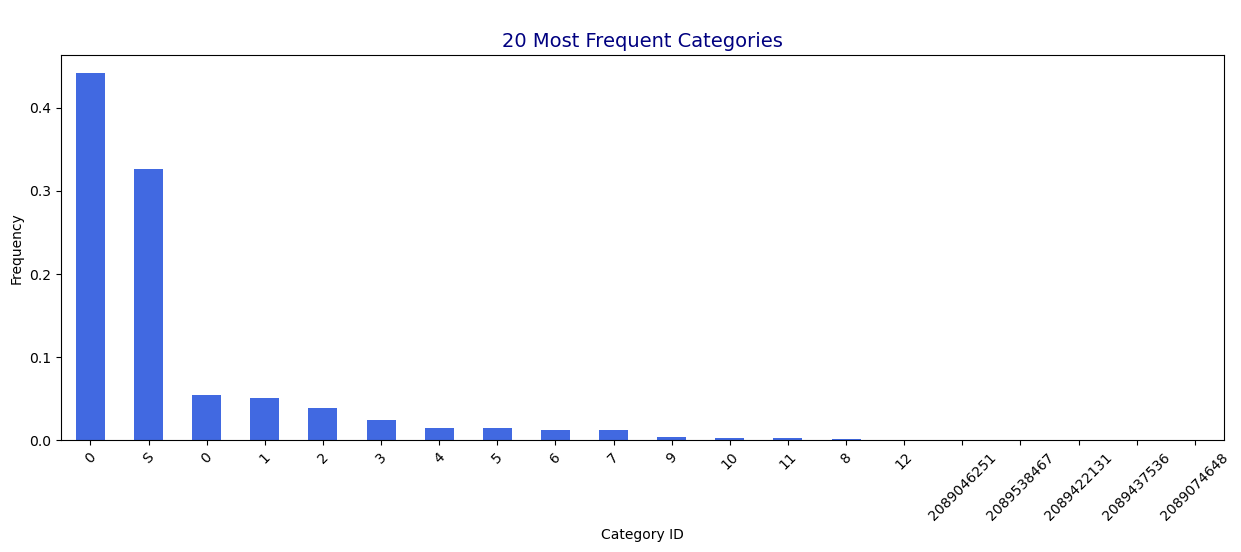

In [3]:
# Import matplotlib
import matplotlib.pyplot as plt 

# Most Frequent categories ids
plt.figure(figsize=(15, 5))

# Top 20 most frequent categories
categories_frequency = stream_df['category'].value_counts().sort_values(ascending=False)[:20]
categories_frequency = categories_frequency/stream_df.shape[0]
categories_frequency.plot(kind='bar', color='royalblue')

# Graph params
plt.title('\n20 Most Frequent Categories', color='navy', size=14)
plt.xlabel('Category ID')
plt.xticks(rotation=45)
plt.ylabel('Frequency')
plt.show()

Let's see how the actual purchases behave relative to the categories browsed

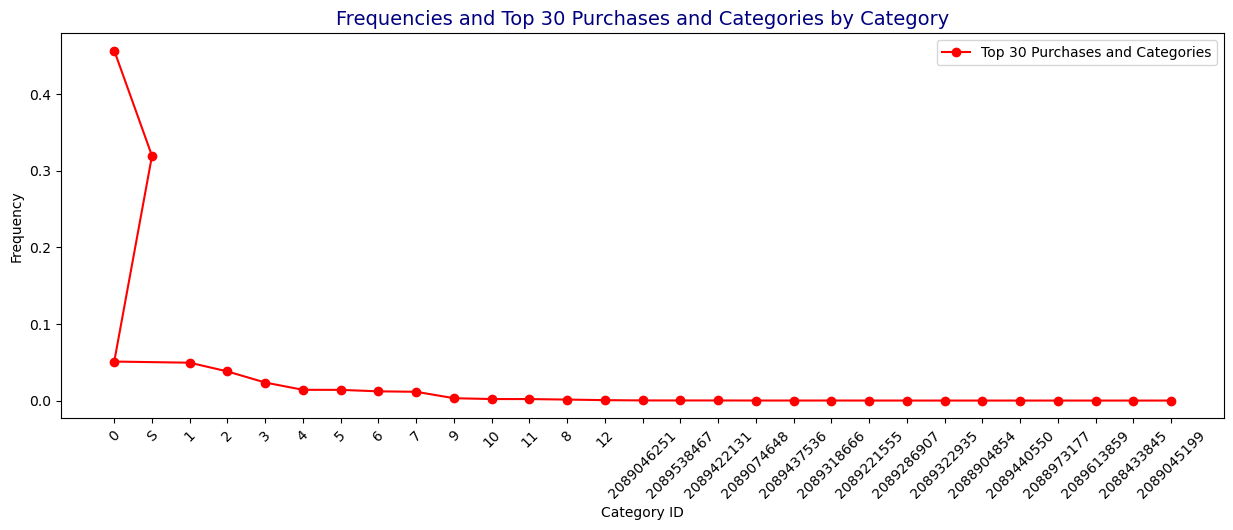

In [102]:
# Filter for rows where 'flg_is_purchase' is True
purchase_df = stream_df[stream_df['flg_is_purchase']]

# Get the top 30 purchased products
top_purchased_products = purchase_df['category'].value_counts().nlargest(30).index

# Filter purchase_df to include only the top 30 purchased products
purchase_df_top30 = purchase_df[purchase_df['category'].isin(top_purchased_products)]

# Get the top 30 categories associated with the top purchased products
top_categories = purchase_df_top30['category'].value_counts().nlargest(30).index

# Filter purchase_df_top30 to include only the top 30 categories
purchase_df_top30_categories = purchase_df_top30[purchase_df_top30['category'].isin(top_categories)]

# Plot both frequencies and purchase frequencies
plt.figure(figsize=(15, 5))

# # Plot of frequencies as bars
# categories_frequency = stream_df['category'].value_counts().sort_values(ascending=False)
# categories_frequency = categories_frequency / stream_df.shape[0]
# plt.bar(categories_frequency.index.astype(str), categories_frequency.values, color='royalblue', label='All Events')

# Plot of purchase frequencies as a line
purchase_categories_frequency = purchase_df_top30_categories['category'].value_counts().sort_values(ascending=False)
purchase_categories_frequency = purchase_categories_frequency / purchase_df_top30_categories.shape[0]
plt.plot(purchase_categories_frequency.index.astype(str), purchase_categories_frequency.values, color='red', marker='o', label='Top 30 Purchases and Categories')

plt.title('Frequencies and Top 30 Purchases and Categories by Category', color='navy', size=14)
plt.xlabel('Category ID')
plt.xticks(rotation=45)
plt.ylabel('Frequency')
plt.legend()
plt.show()



We see that all brand searches are a very small proportion of the clicks. Therefore, we will bundle them together for the time being. Anything with more than 3 characters will be bundled as "brand search"

C:\Users\Bernardo Carvalho\AppData\Local\Temp\ipykernel_15164\1782230790.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  stream_df['category'] = stream_df['category'].str.replace(r'\b[\w\s]{3,}\b', 'brand_search')


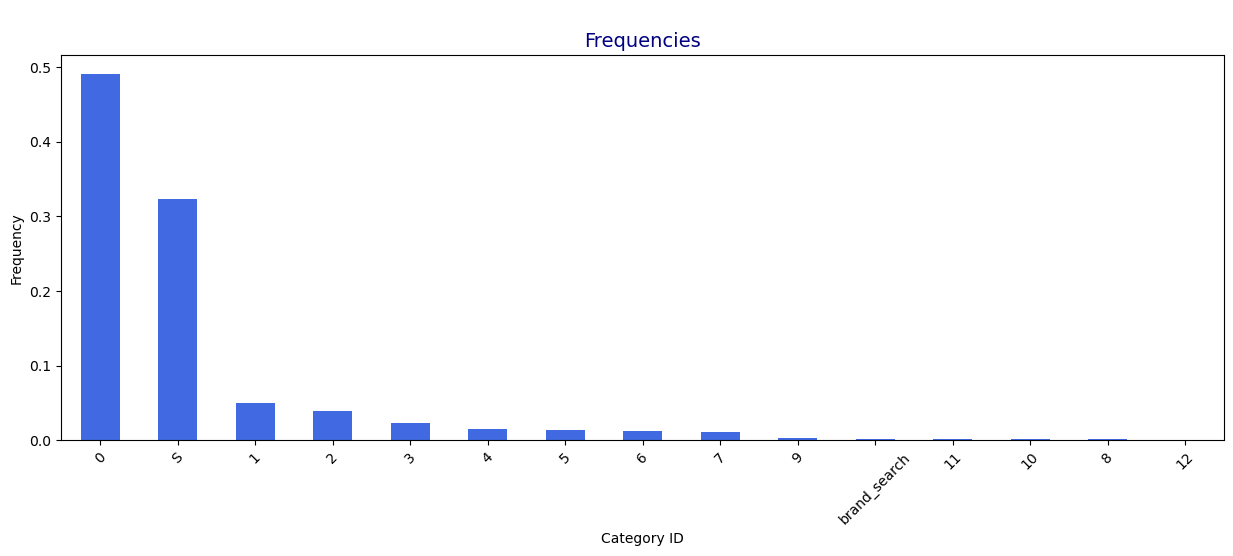

In [43]:
stream_df['category'] = clicks_df['category'].astype(str)

stream_df['category'] = stream_df['category'].str.replace(r'\b[\w\s]{3,}\b', 'brand_search')

plt.figure(figsize=(15, 5))

# Plot of frequencies
categories_frequency = stream_df['category'].value_counts().sort_values(ascending=False)
categories_frequency = categories_frequency/stream_df.shape[0]
categories_frequency.plot(kind='bar', color='royalblue')


plt.title('\nFrequencies', color='navy', size=14)
plt.xlabel('Category ID')
plt.xticks(rotation=45)
plt.ylabel('Frequency')
plt.show()


Now, we want to understand the graph behavior of the customers. i.e: from which node them jump from and to. The plot above gives us a sense, but in order to get deeper we will plot a network visualization of the stream.

In [94]:
# Group by session_id and apply shift() within each group
stream_df['next_category'] = stream_df.groupby('session_id')['category'].shift(-1)
stream_df['next_item_id'] = stream_df.groupby('session_id')['item_id'].shift(-1)
stream_df['next_timestamp'] = stream_df.groupby('session_id')['timestamp_click'].shift(-1)

# Calculate time_to_next_click within each group
stream_df['time_to_next_click'] = stream_df.groupby('session_id')['next_timestamp'].diff()

# For the last row within each session_id, set "end" for next_category
stream_df.loc[stream_df.groupby('session_id').tail(1).index, 'next_category'] = 'end'


In [95]:
stream_df[~stream_df['category'].isin([0,'0'])].head(50)

,session_id,timestamp_click,item_id,category,time_to_purchase,flg_is_purchase,next_category,next_item_id,next_timestamp,time_to_next_click
14660944,4844569,2014-06-14 19:35:34.267,214836512,S,NaT,False,S,214836512.0,2014-06-14 19:35:34.859,0 days 00:00:00.592000
14660945,4844569,2014-06-14 19:35:34.859,214836512,S,NaT,False,end,NaN,NaT,NaT
14660950,4844572,2014-06-10 08:46:22.875,214829310,4,NaT,False,end,NaN,NaT,NaT
14660951,4844573,2014-06-11 10:34:29.856,214533022,4,NaT,False,4,214533022.0,2014-06-11 10:45:11.528,NaT
14660952,4844573,2014-06-11 10:45:11.528,214533022,4,NaT,False,end,NaN,NaT,NaT
14660953,4844574,2014-06-12 20:59:39.816,214836512,4,NaT,False,4,214836512.0,2014-06-12 21:03:17.581,NaT
14660954,4844574,2014-06-12 21:03:17.581,214836512,4,NaT,False,end,NaN,NaT,NaT
14660955,4844576,2014-06-16 15:18:07.009,214839971,4,NaT,False,4,214839960.0,2014-06-16 15:18:54.961,NaT
14660956,4844576,2014-06-16 15:18:54.961,214839960,4,NaT,False,S,214848178.0,2014-06-16 15:19:15.037,0 days 00:00:20.076000
14660957,4844576,2014-06-16 15:19:15.037,214848178,S,NaT,False,end,NaN,NaT,NaT


In [83]:
stream_df['category'] = clicks_df['category']

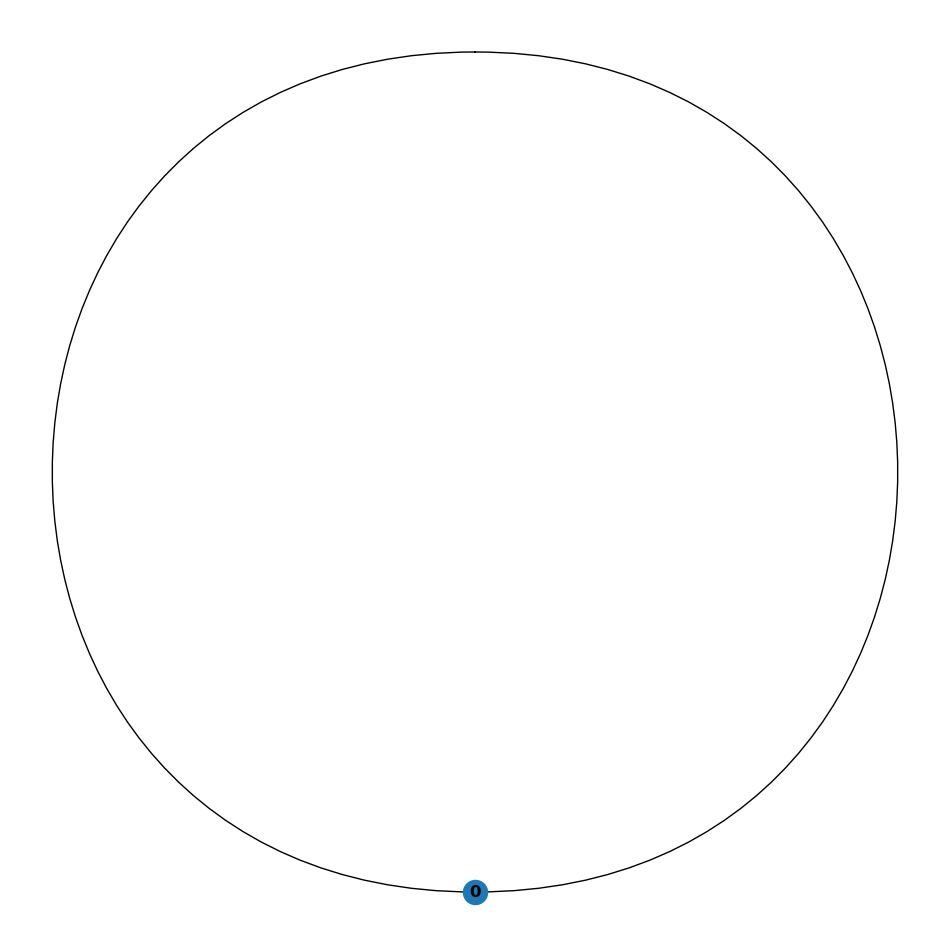

In [80]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a graph
G = nx.from_pandas_edgelist(stream_df.head(10000000), source='category', target='next_category', edge_attr=True)

# Create a list to hold the edges to remove
edges_to_remove = []

# Create new figure and axis
fig, ax = plt.subplots(figsize=(12, 12))

# Generate layout for the graph
pos = nx.spring_layout(G)

# Draw the graph on the axis
nx.draw(G, pos, with_labels=True, font_weight='bold', ax=ax)

# Show the plot
plt.show()


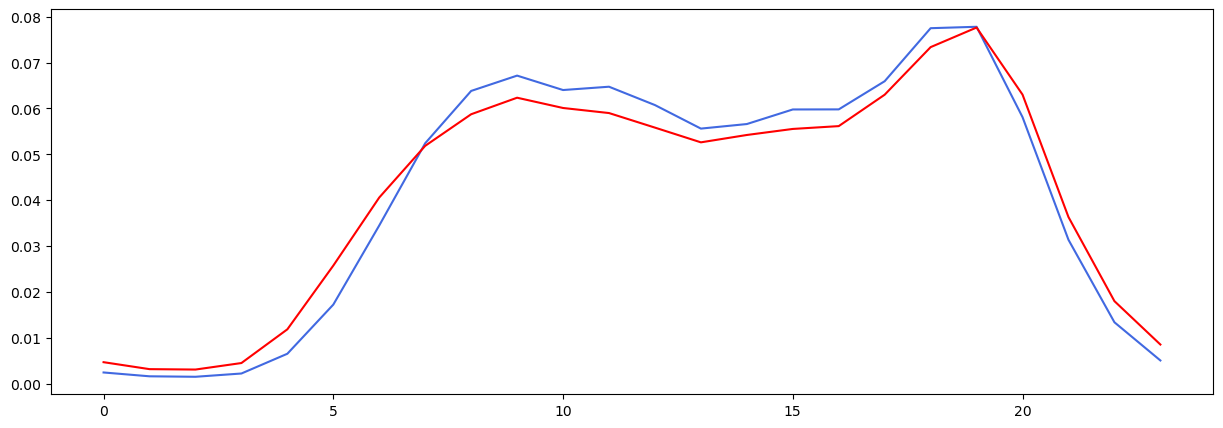

In [67]:
plt.figure(figsize=(15, 5))


# Plot clicks and purchase proportions by hour
buys_hourly_proportions = buys_df['timestamp'].dt.hour.value_counts(normalize=True).sort_index()
clicks_hourly_proportions = clicks_df['timestamp'].dt.hour.value_counts(normalize=True).sort_index()

# plot params
plt.plot(buys_hourly_proportions, color='royalblue')
plt.plot(clicks_hourly_proportions, color='red')
plt.show()


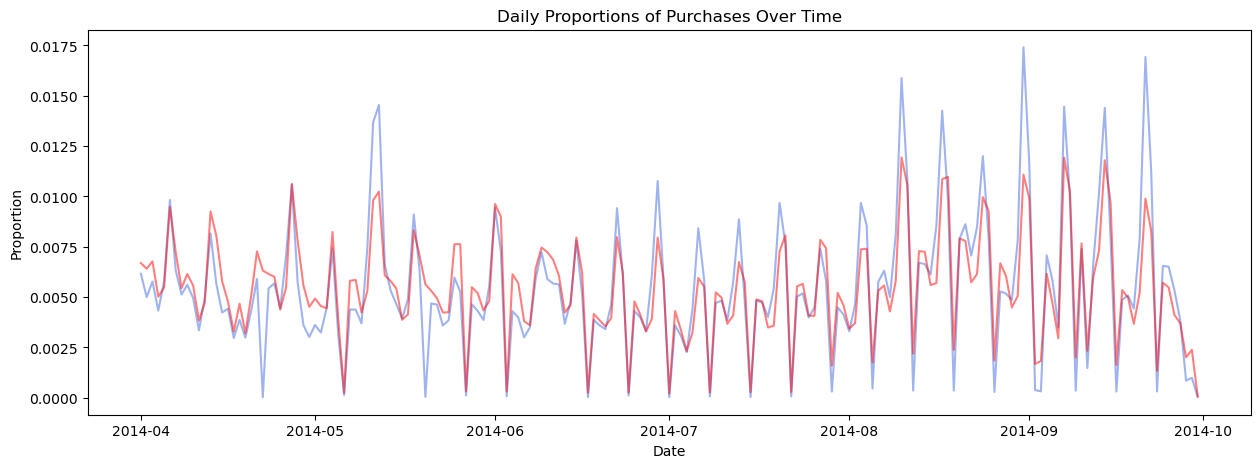

In [79]:
plt.figure(figsize=(15, 5))


buys_daily_proportions = buys_df['timestamp'].dt.date.value_counts(normalize=True).sort_index()
clicks_daily_proportions = clicks_df['timestamp'].dt.date.value_counts(normalize=True).sort_index()

# Plot daily proportions of purchases over time
plt.plot(buys_daily_proportions.index, buys_daily_proportions.values, color='royalblue', alpha=0.5)
plt.plot(clicks_daily_proportions.index, clicks_daily_proportions.values, color='red', alpha=0.5)
plt.xlabel('Date')
plt.ylabel('Proportion')
plt.title('Daily Proportions of Purchases Over Time')
plt.show()



## Feature Engineering

After understanding the streams and setting up the data, we will need to create the features we will use for the model

We can basically split the problem into two. The first is a classical discrimation problem, where our goal is to predict a boolean label (buy or no buy) based on some input features X. The second part of the problem is to be treated as a recommendation problem. For simplicity, we will start with the discrimination problem as a guideline for our feature engineering efforts. Then, we apply what we have built to the recommendation problem in the next phase. The raitonale here is that these questions are ordered. That is, we first need to answer if the session is expected to result in a purchase. Only then we are interested in learning what the purchases are going to be

### Discrimination problem

Basically, our goal will be to predict buy and items based on a session. Therefore, our input data X is a dataset based on sessions, not clicks. Hence, the first thing we need to do is to construct this dataset. Then, the features that comprise X will be determined from what we take from the original datasets. We will start with a top-down approach, in which we start with a very simplistic model, and make incremental improvements towards our maximum performance. The first step is in training the dataset with a very naive approach: Number of clicks and buy probability. For that, we will use three ml models to benchmark:

 - Linear regression
 - Decision trees
 - Neural networks

In [6]:
# Create unique sessions dataset
sessions = clicks_df.groupby('session_id').size().reset_index(name='count_of_clicks')

# Show the first few rows of the sessions dataset

sessions_merged = pd.merge(sessions, buys_df[['session_id','item_id']], on='session_id', how='left')

sessions_merged.head()

# Create y target variable
sessions_merged['purchase'] = sessions_merged['item_id'].notnull()

# Drop the item_id column
sessions_merged.drop('item_id', axis=1, inplace=True)

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier


# Split the data into training and testing sets
X = sessions_merged[['count_of_clicks']]

y = sessions_merged['purchase']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create a logistic regression model
log_reg = LogisticRegression()

# Fit the model
log_reg.fit(X_train, y_train)


# Create a random forest model
rf = RandomForestClassifier()

# Fit the model
rf.fit(X_train, y_train)


RandomForestClassifier()

In [8]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
log_reg_preds = log_reg.predict(X_test)
rf_preds = rf.predict(X_test)

# Calculate the accuracy, precision, recall, and F1 scores
log_reg_accuracy = accuracy_score(y_test, log_reg_preds)
log_reg_precision = precision_score(y_test, log_reg_preds)
log_reg_recall = recall_score(y_test, log_reg_preds)
log_reg_f1 = f1_score(y_test, log_reg_preds)

rf_accuracy = accuracy_score(y_test, rf_preds)
rf_precision = precision_score(y_test, rf_preds)
rf_recall = recall_score(y_test, rf_preds)
rf_f1 = f1_score(y_test, rf_preds)

# Print the results
print('Logistic Regression Model')
print('Accuracy: {}'.format(log_reg_accuracy))
print('Precision: {}'.format(log_reg_precision))
print('Recall: {}'.format(log_reg_recall))
print('F1 Score: {}'.format(log_reg_f1))
print('\n')
print('Random Forest Model')
print('Accuracy: {}'.format(rf_accuracy))
print('Precision: {}'.format(rf_precision))
print('Recall: {}'.format(rf_recall))
print('F1 Score: {}'.format(rf_f1))


Logistic Regression Model
Accuracy: 0.8918026742732967
Precision: 0.640312084689061
Recall: 0.161743468937116
F1 Score: 0.2582521804424421


Random Forest Model
Accuracy: 0.8923196537114001
Precision: 0.6125525400861398
Recall: 0.20497422881799846
F1 Score: 0.3071642159998439


Plot ROC-AUC curve lift

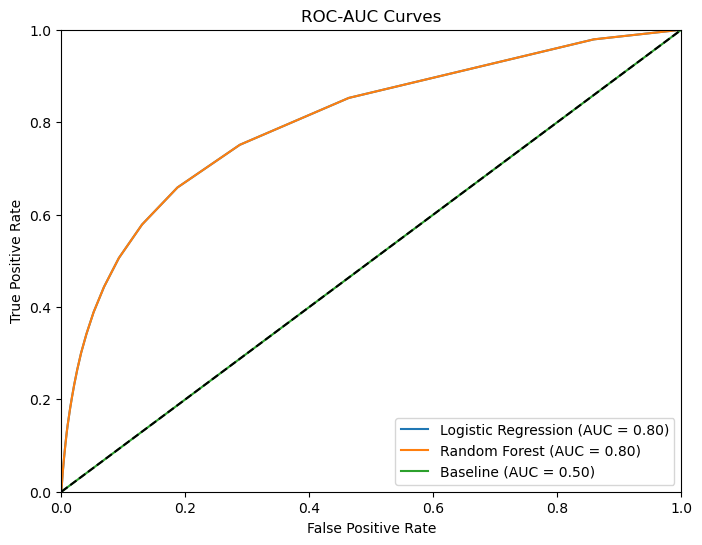

In [9]:
# Import the accuracy metric
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

# Get the predicted probabilities for the logistic regression model
y_pred_log_reg = log_reg.predict_proba(X_test)[:, 1]

# Get the predicted probabilities for the random forest model
y_pred_rf = rf.predict_proba(X_test)[:, 1]

# Calculate the false positive rate, true positive rate, and thresholds for the logistic regression model
fpr_log_reg, tpr_log_reg, thresholds_log_reg = roc_curve(y_test, y_pred_log_reg)

# Calculate the false positive rate, true positive rate, and thresholds for the random forest model
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_pred_rf)

# Calculate the false positive rate, true positive rate, and thresholds for the baseline
fpr_baseline, tpr_baseline, thresholds_baseline = roc_curve(y_test, [0] * len(y_test))

# Calculate the AUC for the logistic regression model
auc_log_reg = auc(fpr_log_reg, tpr_log_reg)

# Calculate the AUC for the random forest model
auc_rf = auc(fpr_rf, tpr_rf)

# Calculate the AUC for the baseline
auc_baseline = auc(fpr_baseline, tpr_baseline)

# Plot the ROC-AUC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_log_reg, tpr_log_reg, label='Logistic Regression (AUC = {:.2f})'.format(auc_log_reg))
plt.plot(fpr_rf, tpr_rf, label='Random Forest (AUC = {:.2f})'.format(auc_rf))
plt.plot(fpr_baseline, tpr_baseline, label='Baseline (AUC = {:.2f})'.format(auc_baseline))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curves')
plt.legend(loc='lower right')
plt.show()

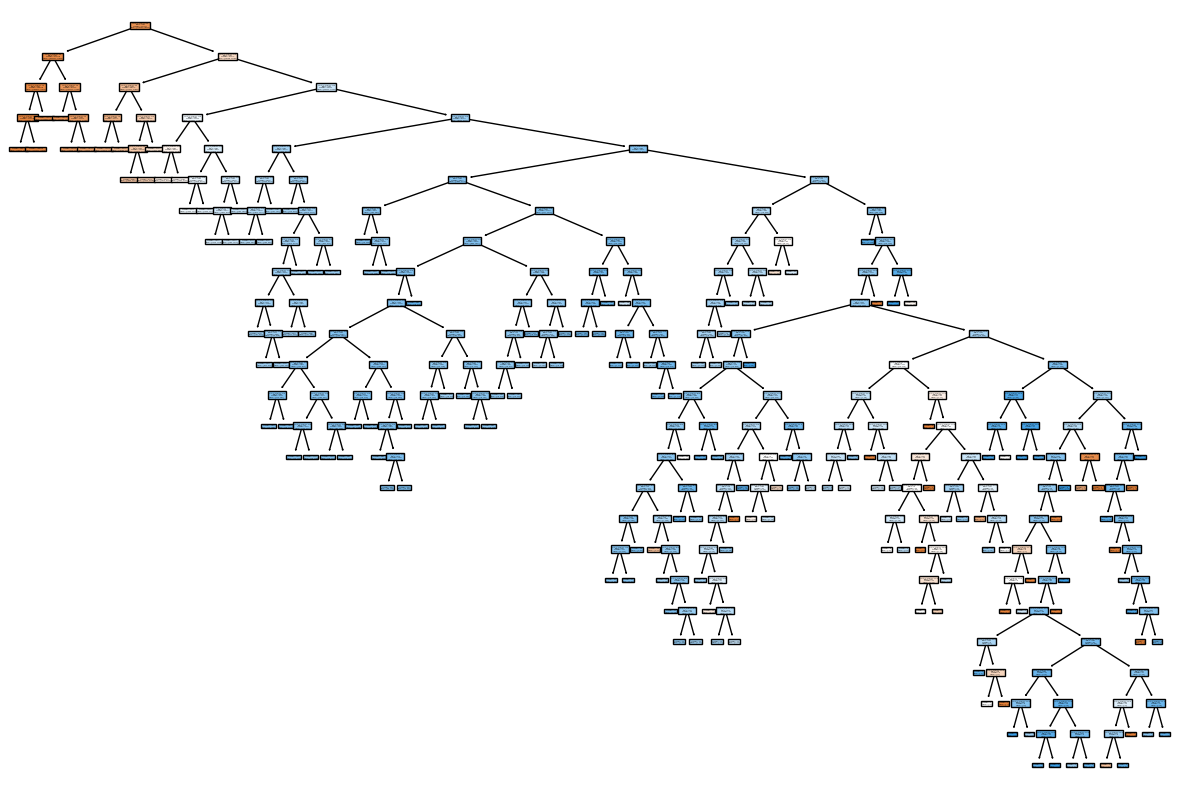

In [10]:
from sklearn import tree

# Get the first decision tree from the random forest model
decision_tree = rf.estimators_[0]

# Plot the decision tree
plt.figure(figsize=(15, 10))
tree.plot_tree(decision_tree, filled=True, feature_names=X.columns)
plt.show()


**Features to create and investigate**

Come up with some segments upfront and see if we can identify them

1. Time since last click
2. Time of day (hour)
3. Clicks on category
4. Clicks on item
5. Item similarity?
6. Study the most common click streams
    i. Which of them result in a purchase?

Features of the buyers dataset:

1. Item price


Check item click occurance and buy occurence of items (to see if some bundling is necessary)